# Project 1



In this project we will look into modelling the heat distribution in anisotropic materials. By Fourier's law, we are given the following model:

$$
-\nabla \cdot (\kappa \nabla u) =f \qquad \text{ in } \Omega
$$

We can reformulate this problem as 

$$
-(a+1)\partial_x^2u - 2r\partial_x\partial_yu - r^2 \partial_y^2u=-a \partial_x^2u - (\textbf{d}_2\cdot\nabla)^2 u = f
$$

where $\textbf{d}_2=(1,r)^\top$

In [1]:
#importing libraries
import numpy as np
from scipy.sparse import diags, bmat, bsr_matrix, eye
from scipy.sparse.linalg import spsolve
import matplotlib.pyplot as plt
from matplotlib import cm

In [2]:
#Function provided by our lecturer in order to plot our numerical solutions

def plot_solution(x, y, U, txt='Solution'):
    fig, ax = plt.subplots(subplot_kw={"projection": "3d"})
    X, Y = np.meshgrid(x,y)
    ax.plot_surface(X, Y, U, cmap=cm.PiYG)
    #ax.view_init(azim=0)              # Rotate the figure
    plt.xlabel('x')
    plt.ylabel('y')
    plt.tight_layout()
    plt.title(txt)

## a)

In this task, we are working with a PDE of the form
$$
-\mathcal{L} u = -k u_{xx}-2bu_{xy}-cu_{yy}-du_x-eu_y-lu = f \qquad \in \Omega
$$

we need to discretize this, i.e. find coefficients $\alpha_{PQ_i}$ such that

$$
\begin{aligned}
-\mathcal{L} u_p &= -\mathcal{L}_h u_p + \tau_p\\
-\mathcal{L} U_p &= \alpha_{pp}U_p - \sum_{i=1}^s \alpha_{PQ_i} U_{Q_i}
\end{aligned}
$$

from the lectures, we know that we can determine these coefficients by following the conditions underneath (following from a Taylor expansion)

$$
\begin{aligned}
h^0u_p: \qquad &\alpha_{pp}-\sum_{i=1}^s\alpha_{PQ_i}=-l_p\\
h^1u_x: \qquad &-h\sum_{i=1}^s\alpha_{PQ_i} \xi_i=-d_p\\
h^1u_y: \qquad &-h\sum_{i=1}^s\alpha_{PQ_i} \eta_i=-e_p\\
h^2u_{xx}: \qquad &-\frac{h^2}{2}\sum_{i=1}^s\alpha_{PQ_i} \xi_i^2=-k_p\\
h^2u_{xy}: \qquad &-h^2\sum_{i=1}^s\alpha_{PQ_i} \xi_i \eta_i=-2b_p\\
h^2u_{yy}: \qquad &-\frac{h^2}{2}\sum_{i=1}^s\alpha_{PQ_i} \eta_i^2=-c_p\\
\end{aligned}
$$

we have chosen to split our differential equation into two different cases, by looking at

$$
-\mathcal{L}_1 u = - a \partial_x^2 u \qquad -\mathcal{L}_2 u = -(\textbf{d}_2\cdot\nabla)^2 u
$$

for $\mathcal{L}_1$, we use the usual central difference scheme, which is known as

$$
-\mathcal{L}_1 u_m^n =  -\frac{a}{h^2} \left(u_{m+1}^n - 2u_m^n + u_{m-1}^n \right) + O(h^2)
$$

for $\mathcal{L}_2$, we also use a central difference scheme, with points along the directional derivative:

$$
-\mathcal{L}_{2_h} U_m^n = \alpha_0 U_m^n - \alpha_1 U_{m-1}^{n-1} - \alpha_2 U_{m+1}^{n+1} 
$$
Because we here discretize in both the x and y direction, we have to determine the above coefficients so that they fulfill the previously presented set of equations. For our problem, we have $k=1, b=2, c=4, l=e=d=0$.
With $r=2$ we get a step size of $\sqrt{5}h$

we now have the following conditions:

$$
\begin{aligned}
\alpha_0-\alpha_1-\alpha_2 = 0\\
-\sqrt{5}h \left(\alpha_1\frac{1}{\sqrt{5}} - \alpha_2\frac{1}{\sqrt{5}}\right) = 0\\
-\sqrt{5}h \left(\alpha_1\frac{2}{\sqrt{5}} - \alpha_2\frac{2}{\sqrt{5}}\right) = 0\\
-\frac{5h^2}{2} \left(\alpha_1\frac{1}{5} + \alpha_2\frac{1}{5}\right) = -1\\
- 5h^2 \left(\alpha_1\frac{2}{5} + \alpha_2\frac{2}{5}\right) = -4\\
-\frac{5h^2}{2} \left(\alpha_1\frac{4}{5} + \alpha_2\frac{4}{5}\right) = -4\\
\end{aligned}
$$

this gives $\alpha_0 = \frac{2}{h^2}, \alpha_1=\alpha_2=\frac{1}{h^2}$, so we have

$$
-\mathcal{L}_{2_h} U_m^n =  -{h^2} \left(U_{m+1}^{n+1} - 2U_m^n + U_{m-1}^{n-1} \right)
$$

in total, we have the scheme

$$
-\mathcal{L}_h U_m^n = -a \frac{1}{h^2} (U_{m+1}^n - 2U_m^n + U_{m-1}^n )-\frac{1}{h^2}(U_{m+1}^{n+1} - 2U_m^n + U_{m-1}^{n-1})
$$

To write this in matrix form, we first need to consider an ordering of the points. We have chosen to use a natural ordering, to translate the matrix $U$ into a vector $\textbf{U}$ consisting of the $(M-1)^2$ interior points. We then have

$$
A\textbf{U} = h^2 \textbf{f} + \textbf{b}
$$

with

$$
\begin{aligned}
B &= \text{tridiag}\left\{-a,2(a+1),-a\right\}\\
C &= \text{tridiag}\left\{0, 0 ,-1\right\}\\
\\
A &= \text{tridiag} \left\{C^\top, B, C\right\}
\end{aligned}
$$

WRITE HOW WE DID IT WITH THE BOUNDARY CONDITIONS

In [3]:
def tridiag_sparse(a,b,c,N):
    bidiag_l = np.full(N-1, a)
    diag = np.full(N, b)
    bidiag_u = np.full(N-1, c)
    
    A = diags([bidiag_l, diag, bidiag_u],[-1,0,1])
    return A

In [4]:
def block_tridiag_sparse(A, B, C, N ):
    A = bmat([[B if i == j else A if i-j==-1 else C if i-j==1 else None for i in range(N)] for j in range(N)], format='csc')
    return A

In [5]:
#Test of boundary values-function
def g(x,y):
    lower = x*2
    upper = x*4
    left = y*0
    right = y**2
    
    boundary = {"left": left, "right": right, "lower":lower, "upper": upper}
    return boundary

M=10
x=np.linspace(0,1,M+1)
y=np.linspace(0,2,M+1)
print(g(x, y))

{'left': array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]), 'right': array([0.  , 0.04, 0.16, 0.36, 0.64, 1.  , 1.44, 1.96, 2.56, 3.24, 4.  ]), 'lower': array([0. , 0.2, 0.4, 0.6, 0.8, 1. , 1.2, 1.4, 1.6, 1.8, 2. ]), 'upper': array([0. , 0.4, 0.8, 1.2, 1.6, 2. , 2.4, 2.8, 3.2, 3.6, 4. ])}


In [6]:
def WIP(g, f, M, a):
    h = 1/M
    k = 2*h
    
    print(f"h = {h:.4}, k = {k:.4}")
    
    x = np.linspace(0,1,M+1)
    y = np.linspace(0,2,M+1)
    g = g(x,y)
    
    U = np.zeros((M+1, M+1))
    U[0,:] = g["lower"]
    U[-1,:] = g["upper"]
    U[:,0] = g["left"]
    U[:,-1] = g["right"]
    
    #diags of B
    B = tridiag_sparse(-a, 2*(a+1), -a, M-1)
    C = diags(np.full(M-2,-1),1)
    A = block_tridiag_sparse(C.T, B, C, B.shape[0])
    
    X, Y = np.meshgrid(x[1:-1], y[1:-1])
  
    f_vec = np.ravel(f(X,Y, a))
    
    b_vec = np.zeros((M-1)**2)
    b_vec[1:M-1] = g["lower"][1:M-1]
    b_vec[-(M-1):-1] = g["upper"][-(M-1):-1] 
    b_vec[:-(M-1)+1:M-1] += a*g["left"][1:-1]+g["left"][:M-1] 
    b_vec[(M-1)-1::M-1] += a*g["right"][1:-1]+g["right"][-(M-1):]
    
    U[1:-1,1:-1] = np.reshape(spsolve(A, b_vec+f_vec*h**2), (M-1,M-1))
    
    return x, y, U

In [7]:
def convergence(u_exact, g, f, M=100, P=4): 
    Hconv, Econv = np.zeros(P), np.zeros(P)
    for p in range(P):
        x, y, U = WIP(g, f, M, 1)
        #x = x[1:-1]
        #y = y[1:-1]
        X, Y = np.meshgrid(x,y)
        Eh = u_exact(X,Y)-U
        Hconv[p] = (x[1]-x[0])
        M = 2*M
        #Econv[p] = np.linalg.norm(Eh, ord = np.inf)
        Econv[p]=np.max(Eh)
        np.max(np.abs(Eh))
    order = np.polyfit(np.log(Hconv),np.log(Econv),1)[0]
    return Hconv, Econv, order

h = 0.01, k = 0.02


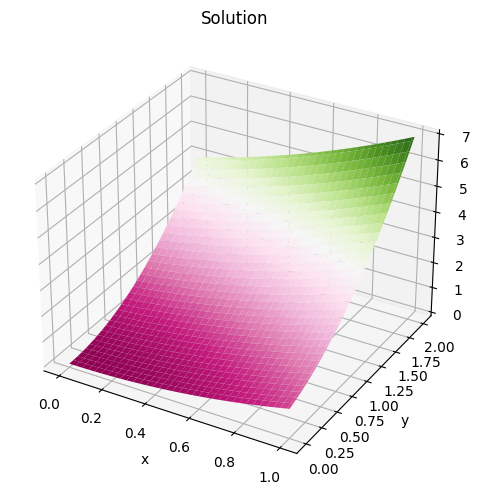

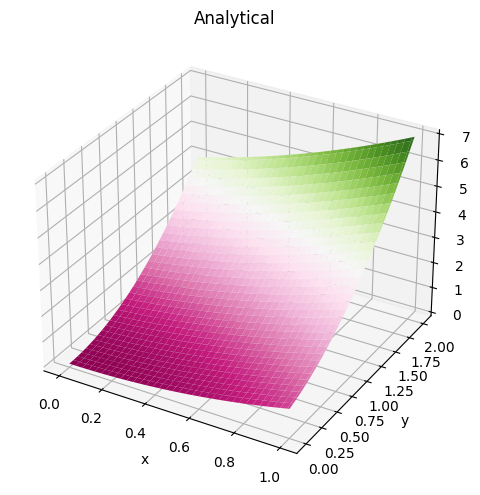

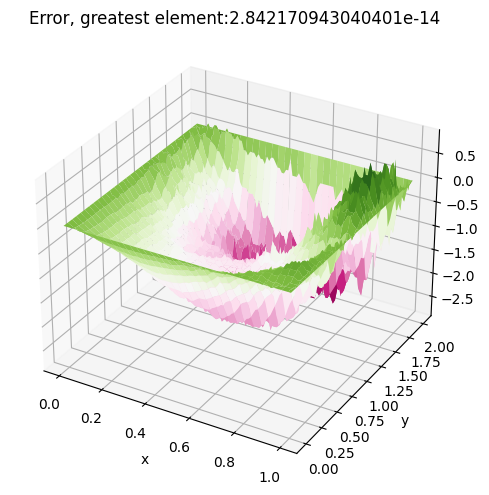

In [8]:
def u(x, y):
    #return x*y*(x-1)*(y-2)
    return x**2 + y**2 + x*y

def f(x, y, a):
    return -(2*a+14)

def g(x,y):
    lower = x**2
    upper = x**2+4+2*x
    left = y**2
    right = 1+y**2+y
    
    boundary = {"left": left, "right": right, "lower":lower, "upper": upper}
    return boundary

x, y, U = WIP(g, f, 100, 1)
plot_solution(x, y, U)

X, Y = np.meshgrid(x, y)
plot_solution(x, y, u(X, Y), "Analytical")

plot_solution(x, y, U-u(X, Y), "Error, greatest element:" + str(np.max(np.abs(U-u(X,Y)))))

We would now like to determine if our scheme is monotone, as this would allow us to make use of the discrete maximum principle, which will be useful in the error analysis.

For our scheme to be monotone, it first needs to be a method of positive coefficients. This is easily shown, as all coefficients are non-negative ($a>0$). We further need to satisfy the "diagonla dominance" condition of the coeffecients, that is
$$
\alpha_{PP} \geq \sum_i \alpha_{PQ_i}
$$
in our case, we get
$$
2(a+1) \geq a+a+1+1 = 2(a+1)
$$
so we have a method of positive coeffcients.

We also need our method to be boundary connected, which essentially means that we must be able to walk from any interior point on our grid to the boundary. This is easily verified from our stencil.


To determine the local truncation error, we need to do a Taylor expansion.

We have

$$
\begin{aligned}
u(x_m\pm h, y_n) &= u_{m\pm 1}^n = u_m^n \pm h\partial_xu_m^n + \frac{h^2}{2} \partial_x^2u_m^n \pm \frac{h^3}{6}\partial_x^3u_m^n + \frac{h^4}{24}\partial_x^4u_m^n \pm O(h^5)
\\
u(x_m\pm h, y_n \pm 2h) &= u_{m\pm 1}^{n \pm 1} = u_m^n \pm h(\partial_x+\partial_y)u_m^n + \frac{h^2}{2} (\partial_x+\partial_y)^2u_m^n \pm \frac{h^3}{6}(\partial_x+\partial_y)^3u_m^n + \frac{h^4}{24}(\partial_x+\partial_y)^4u_m^n \pm O(h^5)
\end{aligned}
$$

plugging this into our scheme, we get

$$
\begin{aligned}
-\frac{a}{h^2}(u_{m+1}^n-2u_m^n+u_{m-1}^n) &= -a\partial_x^2u_m^n - a\frac{h^2}{12}\partial_x^4u_m^n + O(h^4)
\\
-\frac{1}{h^2}(u_{m+1}^{n+1}-2u_m^n+u_{m-1}^{n-1}) &= -(\partial_x+2\partial_y^2)^2u_m^n - \frac{h^2}{12}(\partial_x+2\partial_y)^4u_m^n + O(h^4)
\end{aligned}
$$

We then find the local truncation error as

$$
\begin{aligned}
\tau_m^n &= - \mathcal{L}u_m^n - (-\mathcal{L}_hu_m^n) = \frac{h^2}{12}(a\partial_x^4+(\partial_x+2\partial_y)^4)u_m^n + O(h^4)
\\
&= \frac{h^2}{12}((a+1)\partial_x^4+8\partial_x^3\partial_y+24\partial_x^2\partial_y^2+32\partial_x\partial_y^3+16\partial_y^4)u_m^n + O(h^4)
\end{aligned}
$$

giving us a bound

$$
\|\tau\| \leq Dh^2
$$

with 
$$
D=\frac{1}{12}\left((a+1) \max_{\Omega} |\partial_x^4u|+8\max_{\Omega}|\partial_x^3\partial_yu|+24\max_{\Omega}|\partial_x^2\partial_y^2u|+32|\partial_x\partial_y^3u|+16\max_{\Omega}|\partial_y^4u|\right)
$$

meaning that our method has order of consistency $2$.


To investigate stability and get an error bound, we use the comparison function
$$
\phi(x)=\frac{1}{2}x(1-x)
$$
We first note that this function is nonnegative on our domain.
Second, we also find that
$$
\begin{aligned}
-\mathcal{L}_h\phi(x) &= \frac{1}{h^2}(2(a+1)\phi(x)-(a+1)\phi(x+h)-(a+1)\phi(x-h))\\
&= \frac{1}{2h^2}(a+1)\left(2x(1-x)-(x+h)(1-x-h)-(x-h)(1-x+h)\right)\\
&= \frac{a+1}{2h^2}2h^2 = a+1 \geq 1
\end{aligned}
$$

We now use the solution $V$ of $-\mathcal{L}V=f$, with $V=0$ on the boundary.

$$
-\mathcal{L_h}(V_p-\|\textbf{f}\|_\infty \phi_p)= f_p - \|\textbf{f}\|_\infty\mathcal{L}_h \phi_p \leq 0
$$

We can now use the discrete maximum principle, which yields

$$
V_p - \|\textbf{f}\|_\infty \phi_p \leq \max_{\Omega} \{0, V_p-\|\textbf{f}\|_\infty\phi_p\}=0
$$

we now get an upper bound on $V_p$ as

$$
V_p \leq \phi_p \|\textbf{f}\|_\infty 
$$

By doing the same procedure for $(-V, -f)$, we get an equivalent lower bound:

$$
-V_p \leq \phi_p \|-\textbf{f}\|_\infty = \phi_p \|\textbf{f}\|_\infty
$$

together, this yields

$$
\max V_p \leq \max \phi_p \|\textbf{f}\|_\infty = \frac{1}{8} \|\textbf{f}\|_\infty
$$

This also yields an error bound, as we have the relation

$$
e_p = u_p-U_p \Rightarrow -\mathcal{L}e_p = -\tau_p
$$

we also know the value $u$ takes on the boundary, so $e_p = 0$ on $\partial \mathbb{G}$.

By using the bound on $V_p$ derived above, we get

$$
\|\textbf{e}_h\|_\infty \leq \frac{1}{8} \| \tau_h \|_\infty=C h^2
$$

with 

$$
C = \frac{1}{8} D = \frac{1}{96}\left((a+1) \max_{\Omega} |\partial_x^4u|+8\max_{\Omega}|\partial_x^3\partial_yu|+24\max_{\Omega}|\partial_x^2\partial_y^2u|+32|\partial_x\partial_y^3u|+16\max_{\Omega}|\partial_y^4u|\right)
$$


With our test problem $u(x,y)=\sin(\pi x)\cos(2\pi y)$, we get the following error bound:

$$
 \|\textbf{e}_h\|_\infty \leq \frac{1}{96}((a+1)+8\cdot2+24\cdot4+32\cdot8+16\cdot16)\pi^4h^2=\frac{1}{96}\pi^4(a + 625)h^2
$$

with $a=1$, we then have the error bound

$$
\|\textbf{e}_h\|_\infty \leq \frac{313}{48} \pi^4 h^2
$$

## c)

h = 0.01, k = 0.02
h = 0.02, k = 0.04
h = 0.01, k = 0.02
h = 0.005, k = 0.01
h = 0.0025, k = 0.005


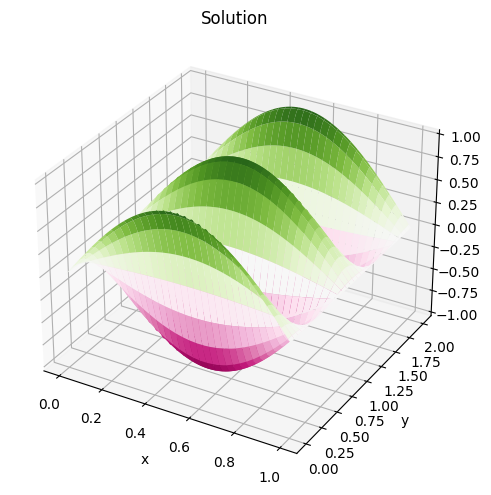

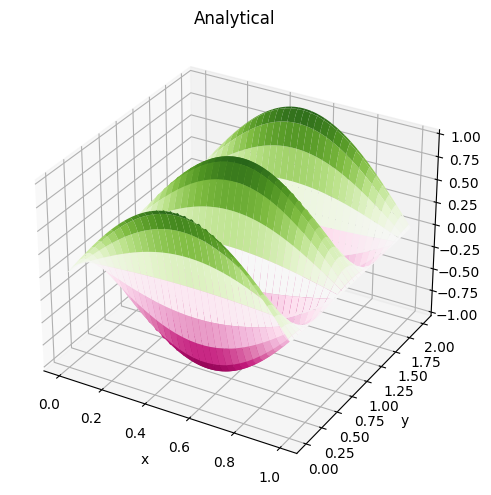

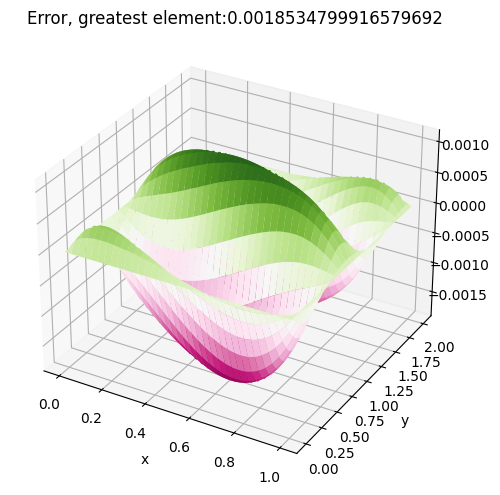

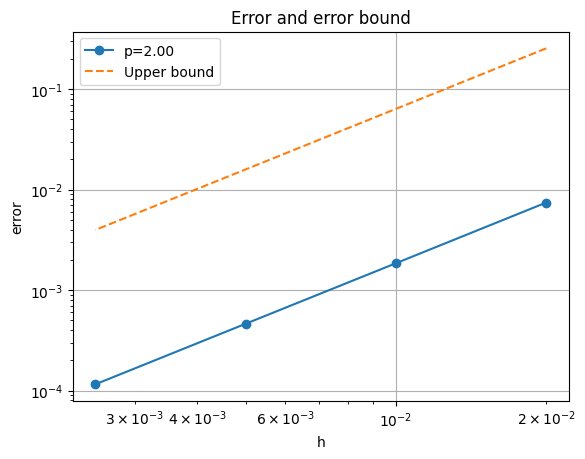

In [9]:
def u(x, y):
    return np.cos(np.pi*y*2)*np.sin(np.pi*x)

def f(x, y, a):
    a1 = -np.pi**2 *(a+1)*np.cos(2*np.pi*y)*np.sin(np.pi*x)
    a2=-8*np.pi**2*np.cos(np.pi*x)*np.sin(2*np.pi*y)
    a3 = -16*np.pi**2*np.cos(2*np.pi*y)*np.sin(np.pi*x)
    return -(a1+a2+a3)

def g(x,y):
    lower = np.sin(np.pi*x)
    upper = np.sin(np.pi*x)
    left = np.full(len(x), 0)
    right = np.full(len(x), 0)
    
    boundary = {"left": left, "right": right, "lower":lower, "upper": upper}
    return boundary

x, y, U = WIP(g, f, 100, 1)
plot_solution(x, y, U)

X, Y = np.meshgrid(x, y)
plot_solution(x, y, u(X, Y), "Analytical")

plot_solution(x, y, U-u(X, Y), "Error, greatest element:" + str(np.max(np.abs(U-u(X,Y)))))

H, E, p = convergence(u, g, f, M=50, P=4)

plt.figure()
plt.loglog(H, E, "o-", label="p={:.2f}".format(p))
plt.loglog(H, (H**2*313/48*np.pi**4), "--", label="Upper bound")
plt.grid("on")
plt.xlabel("h")
plt.ylabel("error")
plt.title("Error and error bound")
plt.legend()
plt.show()

h = 0.01, k = 0.02
h = 0.02, k = 0.04
h = 0.01, k = 0.02
h = 0.005, k = 0.01
h = 0.0025, k = 0.005
(array([0.02  , 0.01  , 0.005 , 0.0025]), array([0.07993976, 0.07902623, 0.07873914, 0.07864827]), 0.007574545904799731)


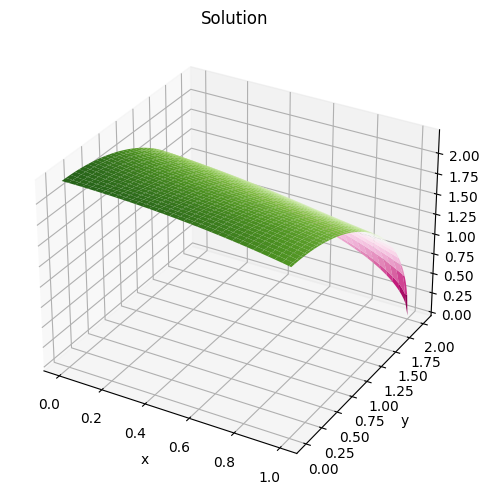

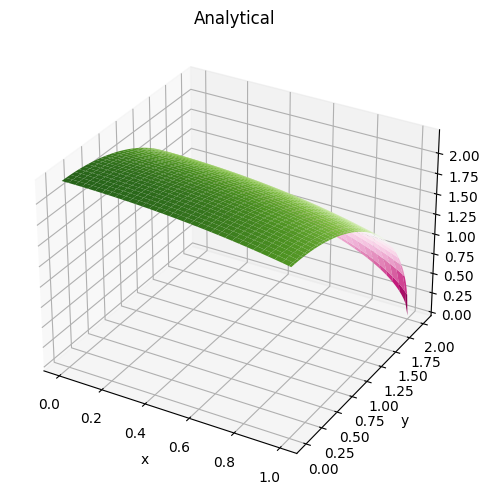

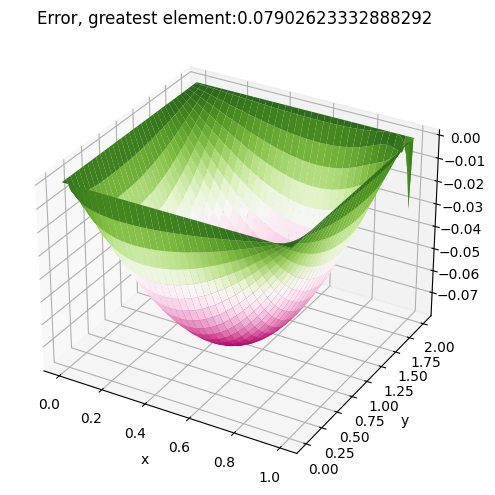

In [10]:
def u(x, y):
    return np.sqrt(-x**2-y**2+5)
def f(x, y, a):
    a1 = (a+1)*(y**2-5)/((-x**2-y**2+5)**(3/2))
    a2=-4*x*y/((-x**2-y**2+5)**(3/2))
    a3 = -4*(y**2+1)/((-x**2-y**2+5)**(3/2))
    return -(a1+a2+a3)

def g(x,y):
    lower = np.sqrt(-x**2+5)
    upper = np.sqrt(-x**2+1)
    left = np.sqrt(-y**2+5)
    right = np.sqrt(-y**2+4)
    
    boundary = {"left": left, "right": right, "lower":lower, "upper": upper}
    return boundary

x, y, U = WIP(g, f, 100, 1)
plot_solution(x, y, U)

X, Y = np.meshgrid(x, y)
plot_solution(x, y, u(X, Y), "Analytical")

plot_solution(x, y, U-u(X, Y), "Error, greatest element:" + str(np.max(np.abs(U-u(X,Y)))))

convergence_result = convergence(u, g, f, M=50, P=4)
print(convergence_result)

## d)


In [11]:
def WIP(g, f, M, a, r):
    h = 1/M
    k = abs(r)*h
    
    print(f"h = {h:.4}, k = {k:.4}")
    
    N = int(2//k)+1 #number of inner horizontal gridlines
    
    x = np.linspace(0,1, M+1)
    y = np.linspace(0,k*N, N+1, endpoint=True)
    
    g = g(x,y)
    
    U = np.zeros((N+1, M+1))
    U[0,:] = g["lower"]
    U[-1,:] = g["upper"]
    U[:,0] = g["left"]
    U[:,-1] = g["right"]
    
    B = tridiag_sparse(-a, 2*(a+1), -a, M-1)
    C = diags(np.full(M-2,-1),1)
    
    X, Y = np.meshgrid(x[1:-1], y[1:-1])
  
    f_vec = np.ravel(f(X,Y, a, r))
    
    b_vec = np.zeros((M-1)*(N-1))
    if r < 0:
        A = block_tridiag_sparse(C, B, C.T, N-1)
        b_vec[:M-2] = g["lower"][-(M-1):-1]
        b_vec[-(M-1)+1:] = g["upper"][1:M-1] 
        b_vec[:-(M-1)+1:M-1] += a*g["left"][1:-1]+g["left"][-(N-1):] 
        b_vec[(M-1)-1::M-1] += a*g["right"][1:-1]+g["right"][:N-1]
        
    else:
        A = block_tridiag_sparse(C.T, B, C, N-1)
        b_vec[1:M-1] = g["lower"][1:M-1]
        b_vec[-(M-1):-1] = g["upper"][-(M-1):-1] 
        b_vec[:-(M-1)+1:M-1] += a*g["left"][1:-1]+g["left"][:N-1] 
        b_vec[(M-1)-1::M-1] += a*g["right"][1:-1]+g["right"][-(N-1):]
    
    U[1:-1,1:-1] = np.reshape(spsolve(A, b_vec+f_vec*h**2), (N-1,M-1))
    
    return x, y, U

k=np.pi/4
N = int(2//k)+1 #number of inner horizontal gridlines
    
x = np.linspace(0,1, M+1)
y = np.linspace(0,k*N, N+1, endpoint=True)

print(y)

[0.         0.78539816 1.57079633 2.35619449]


In [12]:
def convergence2(u_exact, g, f,r=2, a=1, M=100, P=4 ): 
    Hconv, Econv = np.zeros(P), np.zeros(P)
    for p in range(P):
        x, y, U = WIP(g, f, M, a, r)
        X, Y = np.meshgrid(x,y)
        Eh = u_exact(X,Y)-U
        Hconv[p] = (x[1]-x[0])
        M = 2*M
        Econv[p]=np.max(Eh)
        np.max(np.abs(Eh))
    order = np.polyfit(np.log(Hconv),np.log(Econv),1)[0]
    return Hconv, Econv, order

h = 0.01, k = 0.01414
h = 0.02, k = 0.02828
h = 0.01, k = 0.01414
h = 0.005, k = 0.007071
h = 0.0025, k = 0.003536
(array([0.02  , 0.01  , 0.005 , 0.0025]), array([3.76731120e-03, 9.40446968e-04, 2.35323602e-04, 5.88109216e-05]), 2.0002622484147947)


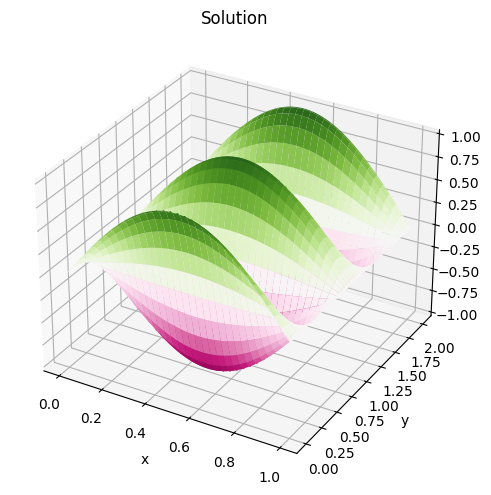

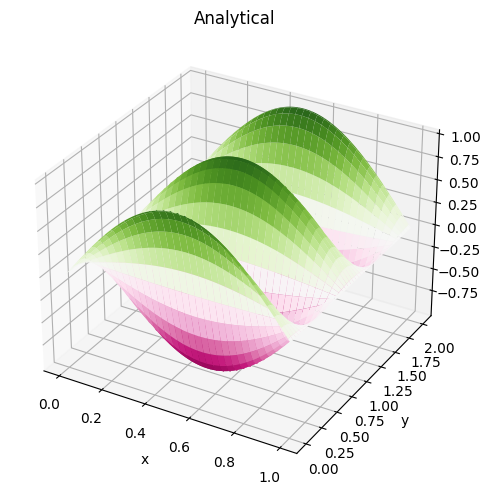

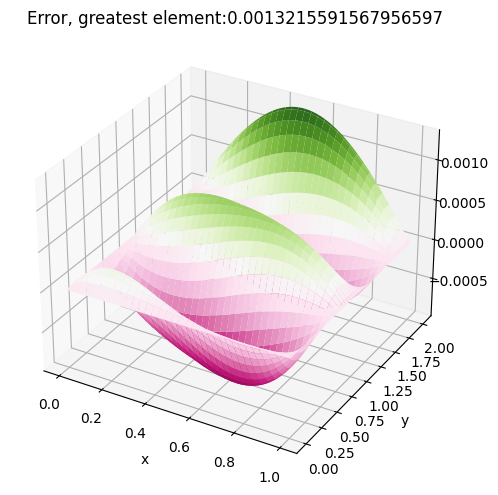

In [13]:
def u(x, y):
    return np.cos(np.pi*y*2)*np.sin(np.pi*x)

def f(x, y, a, r):
    a1 = -np.pi**2 *(a+1)*np.cos(2*np.pi*y)*np.sin(np.pi*x)
    a2=-4*r*np.pi**2*np.cos(np.pi*x)*np.sin(2*np.pi*y)
    a3 = -4*r**2*np.pi**2*np.cos(2*np.pi*y)*np.sin(np.pi*x)
    return -(a1+a2+a3)

def g(x,y):
    lower = np.sin(np.pi*x)
    upper = np.sin(np.pi*x)
    left = np.full(len(y), 0)
    right = np.full(len(y), 0)
    
    boundary = {"left": left, "right": right, "lower":lower, "upper": upper}
    return boundary

x, y, U = WIP(g, f, 100, 1, np.sqrt(2))
plot_solution(x, y, U)

X, Y = np.meshgrid(x, y)
plot_solution(x, y, u(X, Y), "Analytical")

plot_solution(x, y, U-u(X, Y), "Error, greatest element:" + str(np.max(np.abs(U-u(X,Y)))))

convergence_result = convergence2(u, g, f, M=50, P=4, r=-np.sqrt(2))
print(convergence_result)

## Task 2
We now want to consider an irregular grid enclosed by the x-axis, y-axis and the parabola $ y = 1 - x^2$. We want to utilize Dirichlet boundary conditions and we set $\kappa = I$. We want to solve this with two different stategies, and we will start with fattening the boundary. To implement this we first need to compute orthogonal projections on to our domain $\Omega$.

[0.         0.11111111 0.22222222 0.33333333 0.44444444 0.55555556
 0.66666667 0.77777778 0.88888889 1.        ]


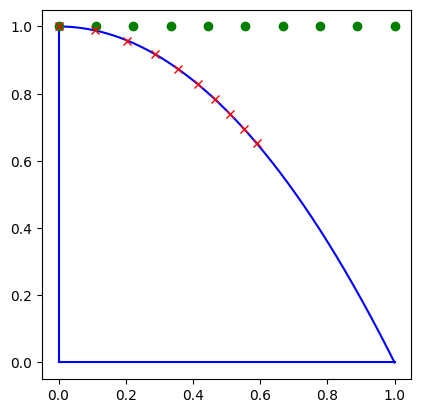

In [14]:
#Plotting the domain, and some normal projections:
M=1000
N=1000
xs = np.linspace(0, 1, M)
ys = np.linspace(0, 1, N)

def curve(x):
    return 1-x**2

#Calculating the projection:

pts_to_be_proj = np.linspace(0, 1, 10)
print(pts_to_be_proj)

#from sympy.solvers import solve
from sympy import solve, symbols, lambdify, Eq
r = symbols('r')

rs = np.zeros(10)

i=0
for pt in pts_to_be_proj:
    rs[i] = solve(pt + r*(1-2*1)-2*r**3)[0]
    i+=1

fig =plt.figure()
ax = fig.add_subplot()
plt.plot(xs, curve(xs), color="blue")
#plt.plot(xs + np.sqrt(2)/5, curve(xs) + np.sqrt(2)/5)
plt.plot(xs, np.full(M, 0), color="blue")
plt.plot(np.full(N, 0), ys, color="blue")
plt.plot(pts_to_be_proj, np.full(10, 1), color="green", marker="o", linestyle="")
plt.plot(rs, np.full(10, 1)-rs**2, color="red", marker="x", linestyle="")
ax.set_aspect('equal', adjustable='box')
plt.show()

In [15]:
M=3
N=5
x = np.linspace(0, 1, M + 1)
y = np.linspace(0, 1, N + 1)
U = np.array([])
k = 1/M
sum = 0


def xFunc(y):
    return np.sqrt(1-y)

def numInner(M, N):
    sum = 0
    U = np.array([])
    k = 1/M
    
    for i in range(1, N):
        tall = int(xFunc(y[i]) // k)
        sum += tall
        U = np.append(U, tall)
        
    return sum, U

tall, V = numInner(M, N)
print(tall)
print(V)
    

6
[2. 2. 1. 1.]


In [16]:
def project_points(x,y):
    rs = np.zeros_like(x)
    for i in range(len(x)):
        rs[i] = solve(x[i] + r*(1-2*y[i])-2*r**3)[0]
    return rs

In [17]:
def WIP2(g, f, M):
    #defining boundary, gamma3, and fattened boundary, sqrt(2)h away from gamma3  
    gamma3 = lambda x : 1-x**2
    fattened_boundary = lambda x, h : (-8*x**2*h**2 - (-4*np.sqrt(2)*x**2 - np.sqrt(2))*np.sqrt(4*x**2 + 1)*h - 4*x**4 + 3*x**2 + 1) / (4*x**2 + 1)
    
    h = 1/M
    print(f"h = {h:.4}")
    
    x = np.linspace(0,1,M+1)
    y = np.linspace(0,1,M+1)
    X,Y = np.meshgrid(x,y)
    indices = np.reshape(np.linspace(0,(M+1)**2-1, (M+1)**2, dtype=np.int64),(M+1,M+1))
    boundary = g(x,y)
    
    inner_nodes = np.logical_and(Y<gamma3(X), np.logical_and(X>0, Y>0))
    inner_indices = indices[inner_nodes]
    
    fattened_boundary_nodes = np.logical_and(gamma3(X)<=Y, np.logical_and(np.logical_and(X>0, Y>0), Y<fattened_boundary(X,h)))
    fattened_boundary_indices = indices[fattened_boundary_nodes]
    
    U = np.zeros((M+1, M+1))
    U[0,:] = boundary["lower"]
    U[:,0] = boundary["left"]
    U=U.ravel()
    
    #x_proj= project_points(X[fattened_boundary_nodes],Y[fattened_boundary_nodes])
    #projecting points on boundary onto curve
    xx, yy, r = symbols('xx yy r', real=True, positive=True)
    sol=solve(xx+r*(1-2*yy)-2*r**3, r)
    np_sol = lambdify((xx, yy), sol[-1])
    x_proj = np_sol(X[fattened_boundary_nodes],Y[fattened_boundary_nodes]) #x-coordinate of projected points
    y_proj = 1-x_proj**2 #y-coordinate of projected points
 
    U[fattened_boundary_indices] = g(x_proj, y_proj)["curve"]
    
    num_inner_row = inner_nodes.sum(axis=1)[1:-1] #number of inner nodes in each row
    num_inner_col = inner_nodes.sum(axis=0)[1:-1] #number of inner nodes in each column

    A = bmat([[tridiag_sparse(-1,4,-1, num_inner_row[i]) if i == j \
               else -eye(num_inner_row[i], num_inner_row[j]) if abs(j-i)==1 \
               else None for j in range(len(num_inner_row))] for i in range(len(num_inner_row))], format='csc')
    
    f_vec = f(X[inner_nodes],Y[inner_nodes])
    b = np.zeros(len(inner_indices))
    
    #indices of b, where we need to add boundary conditions to the RHS
    b_ind_right = np.cumsum(num_inner_row)-1 #need to add point to the right
    b_ind_left = np.cumsum(np.concatenate(([0], num_inner_row[:-1]))) #left
    b_ind_down = np.arange(num_inner_row[0]) #down
    b_ind_up = np.cumsum(np.concatenate(([0], num_inner_row[:-1])))[num_inner_col-1]+np.arange(num_inner_row[0]) #up
    
    #indices of boundary values to be added in b
    U_ind_right = (np.arange(len(num_inner_row))+1)*(M+1) + num_inner_row + 1
    U_ind_up = (num_inner_col+1)*(M+1) + np.arange(len(num_inner_col)) + 1
    
    #adding points to b at indices
    b[b_ind_right] += U[U_ind_right]
    b[b_ind_left] += boundary["left"][1:-1]
    b[b_ind_down] += boundary["lower"][1:-1]
    b[b_ind_up] +=  U[U_ind_up]
    
    U[inner_indices] = spsolve(A, -h**2*f_vec + b)
    U = U.reshape((M+1,M+1))
    
    return x, y, U

h = 0.01


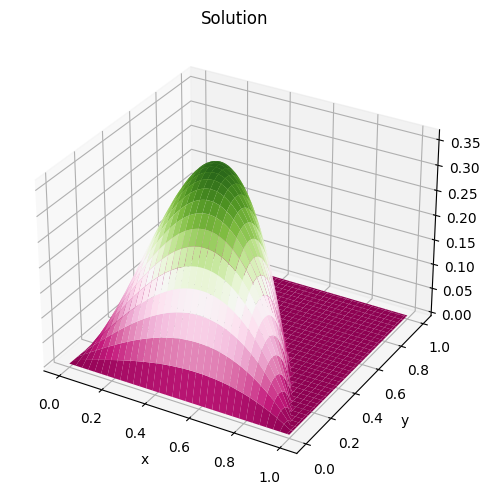

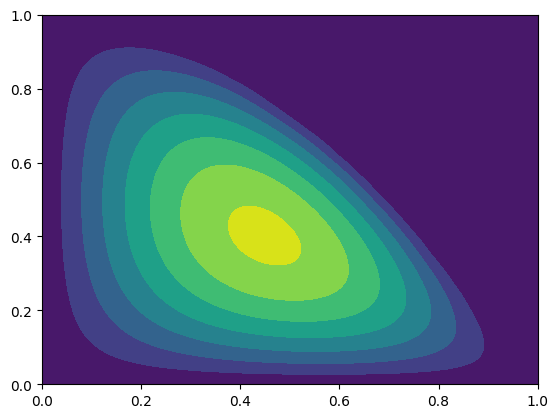

In [18]:
def g(x,y):
    gamma1 = np.zeros_like(x)
    gamma2 = np.zeros_like(y)
    gamma3 = -5*x*y*(x**2+y-1)
    
    boundary = {"lower" : gamma1, "left" : gamma2, "curve" : gamma3 }
    return boundary


def f(x, y):
    return -30*x*y-10*x

x, y, U = WIP2(g, f, 100)
plot_solution(x, y, U)
xx, yy = np.meshgrid(x,y)

plt.figure()
plt.contourf(xx, yy, U)
plt.show()

h = 0.01


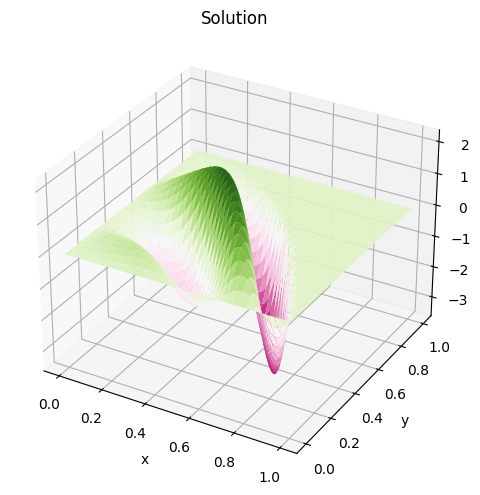

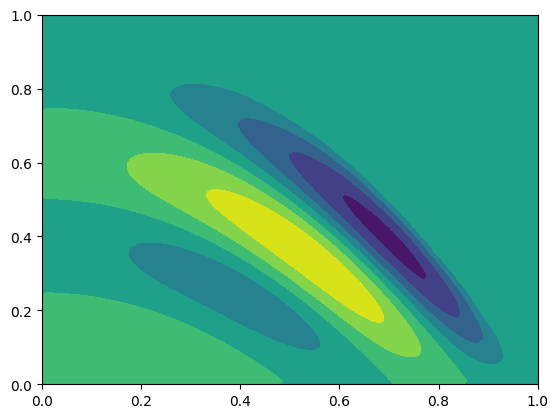

In [19]:
def g(x,y):
    gamma1 = np.zeros_like(x)
    gamma2 = np.zeros_like(y)
    gamma3 = -5*x*y*(x**2+y-1)
    boundary = {"lower" : gamma1, "left" : gamma2, "curve" : gamma3 }
    return boundary

def f(x, y):
    return ((((120 * np.pi) * x) * np.cos(((4 * np.pi) * (x**(2) + y)))) * np.sin((np.pi * y))) \
        + ((((40 * np.pi**(2)) * x) * np.cos((np.pi * y))) * np.cos(((4 * np.pi) * (x**(2) + y)))) \
        - ((((85 * np.pi**(2)) * x) * np.sin((np.pi * y))) * np.sin(((4 * np.pi) * (x**(2) + y)))) \
        - ((((320 * np.pi**(2)) * x**(3)) * np.sin((np.pi * y))) * np.sin(((4 * np.pi) * (x**(2) + y))))

x, y, U = WIP2(g, f, 100)
plot_solution(x, y, U)
xx, yy = np.meshgrid(x,y)
plt.figure()
plt.contourf(xx, yy, U)
plt.show()

h = 0.002


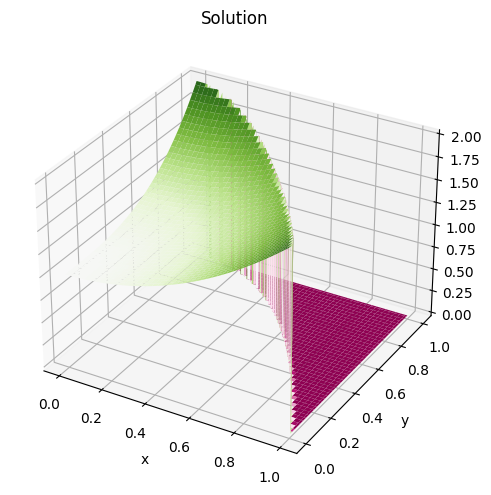

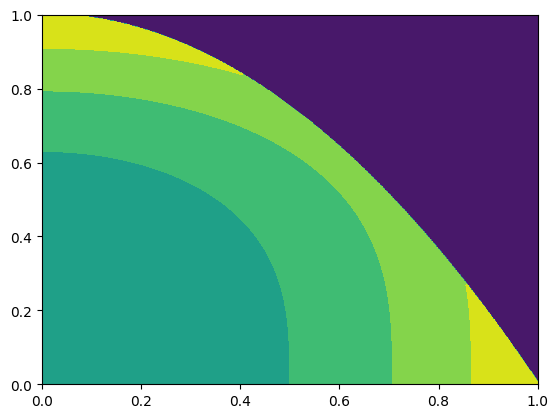

0.003899641505091367


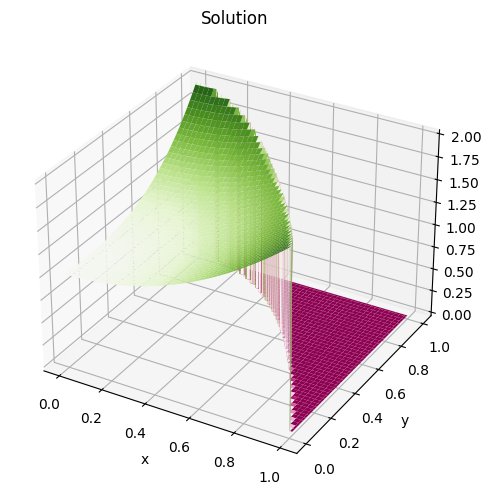

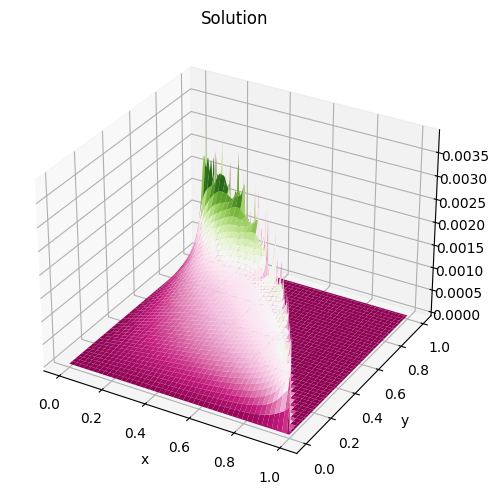

In [20]:
#Non-zero boundaries

def g(x,y):
    gamma1 = 1+x**2
    gamma2 = 1+y**3
    gamma3 = x**2+1+(1-x**2)**3
    boundary = {"lower" : gamma1, "left" : gamma2, "curve" : gamma3 }
    return boundary

def f(x, y):
    return 6*y+2

x, y, U = WIP2(g, f, 500)
plot_solution(x, y, U)
xx, yy = np.meshgrid(x,y)
plt.figure()
plt.contourf(xx, yy, U)
plt.show()

def u(x, y):
    return np.where(y<=1-x**2, 1+x**2+y**3, 0)

u_exact = u(xx, yy)

U[yy>1-xx**2] = 0

plot_solution(x, y, u_exact)

plot_solution(x, y, u_exact-U)

print(np.max(np.abs(u_exact-U)))

In [21]:
def convergence3(u_exact, g, f, M=100, P=4 ): 
    Hconv, Econv = np.zeros(P), np.zeros(P)
    for p in range(P):
        x, y, U = WIP2(g, f, M)
        X, Y = np.meshgrid(x,y)
        Eh = u_exact(X,Y)-U
        Hconv[p] = (x[1]-x[0])
        M = 2*M
        Econv[p]=np.max(Eh)
        np.max(np.abs(Eh))
    order = np.polyfit(np.log(Hconv),np.log(Econv),1)[0]
    return Hconv, Econv, order

convergence_result = convergence3(u, g, f, M=50, P=4)

h = 0.02
h = 0.01
h = 0.005
h = 0.0025


In [22]:
print(convergence_result)

(array([0.02  , 0.01  , 0.005 , 0.0025]), array([0.03022061, 0.01483195, 0.00902208, 0.00439355]), 0.906339858758262)


In [23]:
### Modifying the discretization:

def help(x_ind, y_ind, h, want_y=False, want_x=False):
    return_list = []
    x = (x_ind+1)*h
    y = (y_ind+1)*h
    if want_x:
        return_list.append((np.sqrt(1-y)-x)/h)
    if want_y:
        return_list.append(((1-x**2)-y)/h)
    return return_list
    
print(help(3, 0, 0.2))

[]


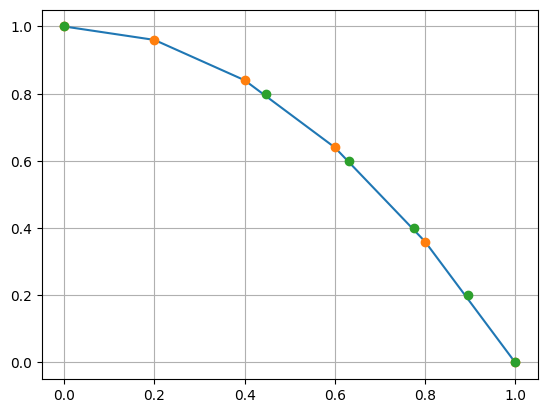

In [24]:
M=5
x = np.linspace(0, 1, M+1)
y = np.linspace(0, 1, M+1)

y_curve_up = 1-x**2
x_curve_up = np.sqrt(1-y_curve_up)

x_curve_right = np.sqrt(1-y)
y_curve_right = 1-x_curve_right**2

plt.figure()
plt.plot(x, 1-x**2)
plt.plot(x_curve_up, y_curve_up, 'o')
plt.plot(x_curve_right, y_curve_right, 'o')
plt.grid()
plt.show()

In [27]:
def WIP3(g, f, M):
    #defining boundary, gamma3, and fattened boundary, sqrt(2)h away from gamma3  
    gamma3 = lambda x : 1-x**2
    
    h = 1/M
    print(f"h = {h:.4}")
    
    x = np.linspace(0,1,M+1)
    y = np.linspace(0,1,M+1)
    X,Y = np.meshgrid(x,y)
    Xu, Yu = X.ravel(), Y.ravel()
    indices = np.reshape(np.linspace(0,(M+1)**2-1, (M+1)**2, dtype=np.int64),(M+1,M+1))
    boundary = g(x,y)
    
    inner_nodes = np.logical_and(Y<gamma3(X), np.logical_and(X>0, Y>0))
    inner_indices = indices[inner_nodes]
    
    U = np.zeros((M+1, M+1))
    U[0,:] = boundary["lower"]
    U[:,0] = boundary["left"]
    U=U.ravel()
    
    num_inner_row = inner_nodes.sum(axis=1)[1:-1] #number of inner nodes in each row
    num_inner_col = inner_nodes.sum(axis=0)[1:-1] #number of inner nodes in each column

    A = bmat([[tridiag_sparse(-1,4,-1, num_inner_row[i]) if i == j \
               else -eye(num_inner_row[i], num_inner_row[j]) if abs(j-i)==1 \
               else None for j in range(len(num_inner_row))] for i in range(len(num_inner_row))], format='csc')
    
    f_vec = f(X[inner_nodes],Y[inner_nodes])
    b = np.zeros(len(inner_indices))
    
    #indices of b, where we need to add boundary conditions to the RHS
    inner_ind_right = np.cumsum(num_inner_row)-1 #need to add point to the right
    inner_ind_left = np.cumsum(np.concatenate(([0], num_inner_row[:-1]))) #left
    inner_ind_down = np.arange(num_inner_row[0]) #down
    inner_ind_up = np.cumsum(np.concatenate(([0], num_inner_row[:-1])))[num_inner_col-1]+np.arange(num_inner_row[0]) #up
    
    #indices of boundary values to be added in b
    grid_ind_right = (np.arange(len(num_inner_row))+1)*(M+1) + num_inner_row
    grid_ind_up = (num_inner_col)*(M+1) + np.arange(len(num_inner_col)) + 1
    
    etay = (1-(Xu[grid_ind_up])**2-Yu[grid_ind_up])/h
    etax = (np.sqrt(1-Yu[grid_ind_right])-Xu[grid_ind_right])/h

    a_left = -2/(etax + 1)
    a_right = -2/(etax*(etax + 1))
    a_x = 2/etax

    a_up = -2/(etay + 1)
    a_down = -2/(etay*(etay + 1))
    a_y = 2/etay

    intersection_ind = np.intersect1d(inner_ind_right, inner_ind_up)
    union_ind = np.union1d(inner_ind_right, inner_ind_up)

    A[union_ind, union_ind] = 2
    A[intersection_ind, intersection_ind] = 0
    A[inner_ind_right, inner_ind_right] += a_x
    A[inner_ind_up, inner_ind_up] += a_y

    A[inner_ind_right, inner_ind_right-1] = a_left
    add_down = inner_ind_up[inner_ind_up>num_inner_row[0]-1]
    A[add_down, add_down - (num_inner_row[num_inner_col-2])[:len(add_down)]] = a_down[:len(add_down)]


    #adding points to b at indices
    #b[b_ind_right] += U[U_ind_right]
    #b[b_ind_left] += boundary["left"][1:-1]
    #b[b_ind_down] += boundary["lower"][1:-1]
    #b[b_ind_up] +=  U[U_ind_up]
    
    U[inner_indices] = spsolve(A, -h**2*f_vec + b)
    U = U.reshape((M+1,M+1))
    
    return x, y, U

h = 0.001


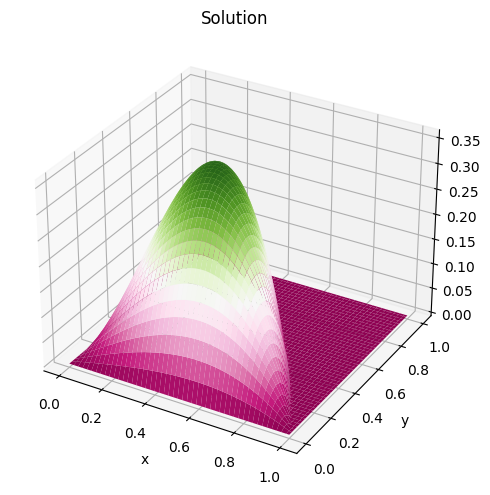

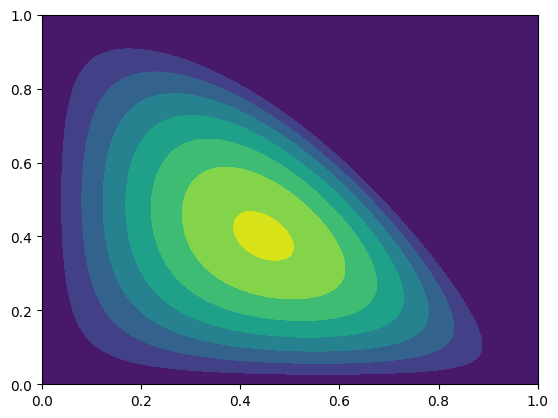

In [28]:
def g(x,y):
    gamma1 = np.zeros_like(x)
    gamma2 = np.zeros_like(y)
    gamma3 = -5*x*y*(x**2+y-1)
    
    boundary = {"lower" : gamma1, "left" : gamma2, "curve" : gamma3 }
    return boundary


def f(x, y):
    return -30*x*y-10*x

x, y, U = WIP3(g, f, 1000)
plot_solution(x, y, U)
xx, yy = np.meshgrid(x,y)

plt.figure()
plt.contourf(xx, yy, U)
plt.show()

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=108cd322-ba6e-45a8-8648-ab5356f85b45' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>